# Basic imports

In [24]:
from math import inf
import matplotlib.pyplot as plt
import numpy as np

In [25]:
import os
import pickle
models_prefix = './models-persisted'

def persist_instance(variable:any, file_name:str):
    if not os.path.exists(models_prefix): os.makedirs(models_prefix)

    with open(f'{models_prefix}/{file_name}.pkl', 'wb') as file:
        pickle.dump(variable, file)

def load_instance(path:str):
    with open(f'{path}', 'rb') as file:
        return pickle.load(file)

# Reading data

In [26]:
from dataController import DataController
from dataDigestor import DataDiggestor

data_path = '../data/collected_data'
data_diggestor = DataDiggestor()
initial_df = data_diggestor.diggest_files_into_single_dataframe(data_path).drop(
    columns=['PT100 3 [ºC]', 'PT100 4 [ºC]', 'Vel. do Ar [m/s]']).reset_index(drop=True)

use_case_df = data_diggestor.diggest_all_data_into_single_df(data_path).drop(
    columns=['PT100 3 [ºC]', 'PT100 4 [ºC]', 'Vel. do Ar [m/s]', 'Ensaio']).reset_index(drop=True)
data_controller_use_case = DataController(use_case_df)


data_controller = DataController(initial_df)
data_controller.df.head()

,Time,PT100 1 [ºC],PT100 2 [ºC],Temp. TH 1 [ºC],Umidade 1 [%],Temp. TH 2 [ºC],Umidade 2 [%],Umidade Produto [%],Ensaio
0,0.000,24.213534,24.500000,20.134013,73.388713,24.182938,90.653755,55.223333,0
1,900.485,27.270283,27.310531,22.176537,65.309984,27.512709,92.391174,48.006667,0
2,1799.039,27.268392,27.397820,24.304439,58.981789,27.571817,93.011919,41.003333,0
3,2699.241,34.421674,29.924256,25.338835,54.499243,27.302546,93.185991,7.083333,0
4,3600.524,45.204301,43.769892,24.544156,56.508994,39.971468,26.113811,2.283333,0


In [27]:
from sklearn.model_selection import train_test_split

interest_column = 'Umidade Produto [%]'
columns_to_drop = ['Ensaio']

X, y = data_controller.get_X_y_datasets(interest_column, columns_to_drop)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Models implementation

### Metrics imports and functions

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
def model_residual_distribution(y_true, y_pred):
    residuals = y_true - y_pred
    mean_residuals = np.mean(residuals)
    plt.hist(residuals, bins=35)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"Residual Distribution graph. Mean = {mean_residuals:.2f}")
    plt.show()

models_result = {}
def model_summary(y_true, X_for_pred, model, verbose=True, result_dict=models_result):
    y_pred = model.predict(X_for_pred)
    score = model.score(X_for_pred, y_true)
    _mse = mean_squared_error(y_true, y_pred)
    _score = score * 100
    result_dict[model.__class__.__name__] = {
        'MSE': _mse,
        'Score': _score
    }
    
    if (verbose):
        print('Mean Squared Error (MSE) lower = better\nScore higher = better\n')
        print(f'MSE\t\t{_mse:.2f}')
        print(f'Score\t\t{_score:.2f}%')

        model_residual_distribution(y_true, y_pred)

    return score

#### Trainer for non idempotent models

> Trains the model multiple times and returns the best scored model acquired during the iterations.

In [30]:
from time import perf_counter
from datetime import timedelta
from statistics import mean

def get_best_from_simple_fit_model(model, X_train, y_train, X_test, y_test, iterations = 1000, verbose=True, persist = True):
    best_score = -inf
    best_model = None

    model_class = model.__class__
    class_name = str(model.__class__).split('\'')[-2].split('.')[-1]
    step = 0.005
    perc = iterations * step
    execution_times = []

    if (verbose): print(f'Training {class_name} model')

    start = perf_counter()
    for i in range(int(iterations)):
        # Measures training progress and time left, desactivate with verbose=False
        if (i%perc == 0 and i != 0 and verbose):
            execution_times.append(round(perf_counter() - start, 3))
            elapsed_time =  mean(execution_times)
            executed_perc = round(i/iterations*100, 1)
            left = int((1 - executed_perc/100)/(step))
            time_left = str(timedelta(seconds=(elapsed_time * left))).split('.')[0]
            print(f'{executed_perc}%\ttraining time left {time_left}s')
            start = perf_counter()

        model = model_class()
        model.fit(X_train, y_train)
        score = model_summary(y_test, X_test, model, False)
        if (score > best_score):
            best_score = score
            best_model = model
    
    if (persist): persist_instance(best_model, class_name)
    return best_model

## Linear Regression

### Ordinary least squares

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		16.47
Score		96.65%


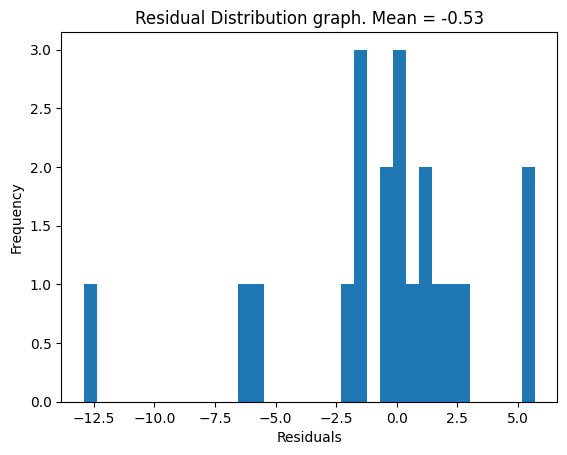

0.9664752287304014

In [31]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

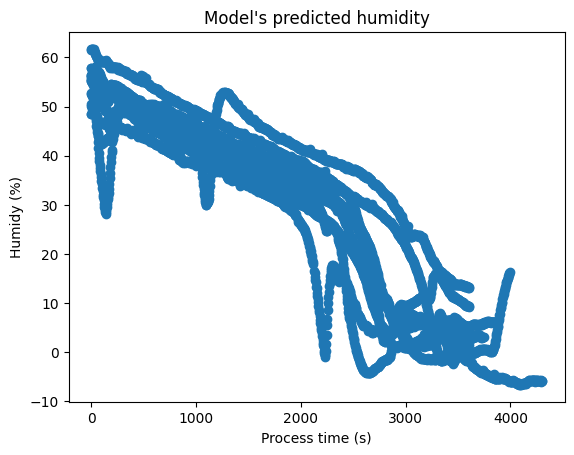

In [39]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Ridge regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		14.28
Score		97.09%


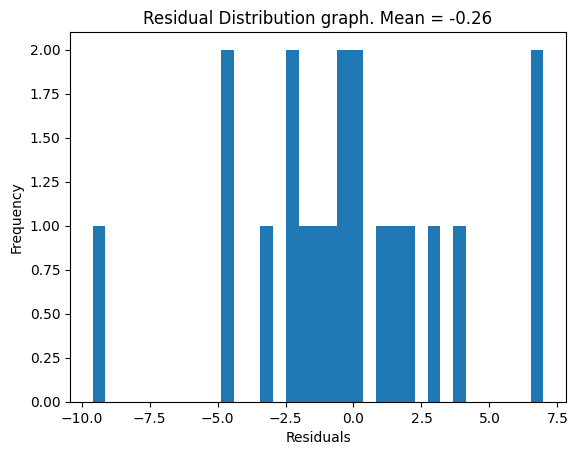

0.9709231156080166

In [40]:
from sklearn import linear_model

model = linear_model.Ridge()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

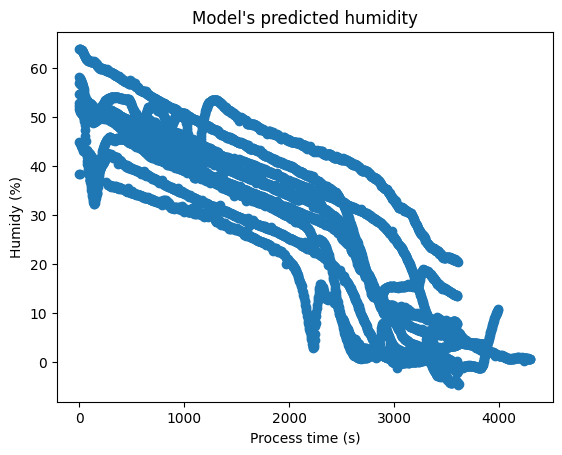

In [41]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Lasso regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		27.21
Score		94.46%


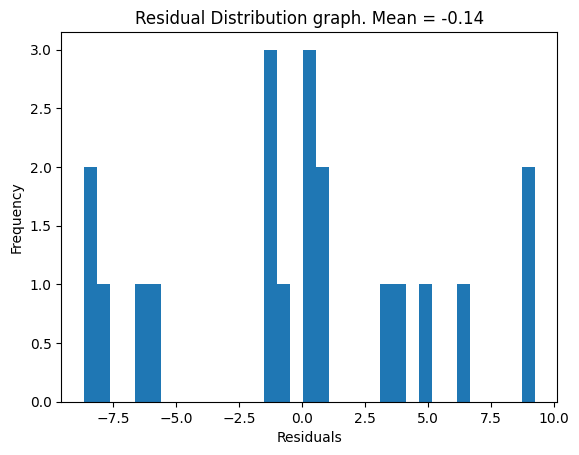

0.9446109599090243

In [42]:
from sklearn import linear_model

model = linear_model.Lasso()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

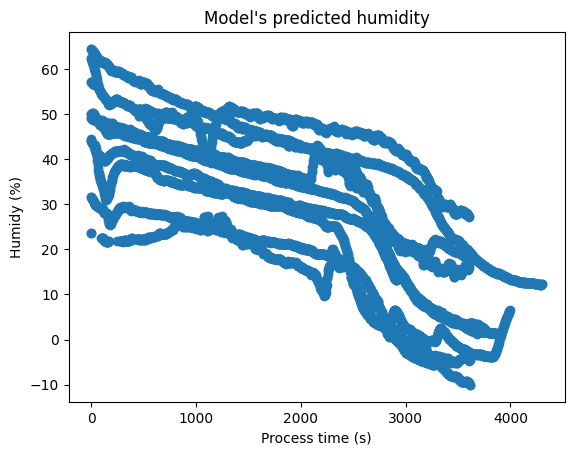

In [43]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Least Angle regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		16.47
Score		96.65%


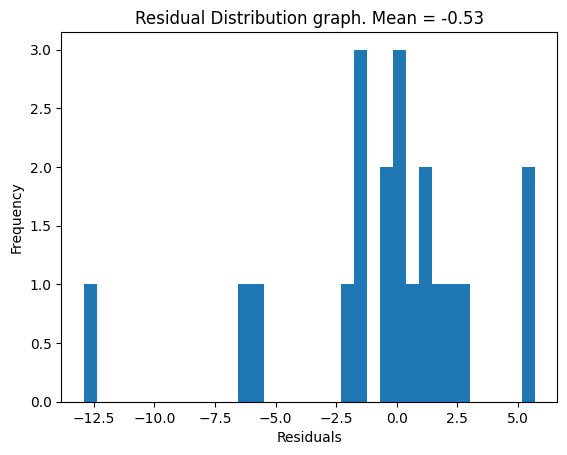

0.9664752287304165

In [44]:
from sklearn import linear_model

model = linear_model.Lars()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

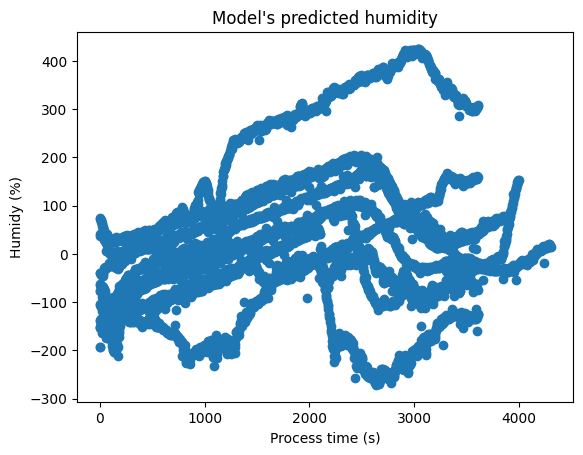

In [45]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### ElasticNet regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		40.05
Score		91.85%


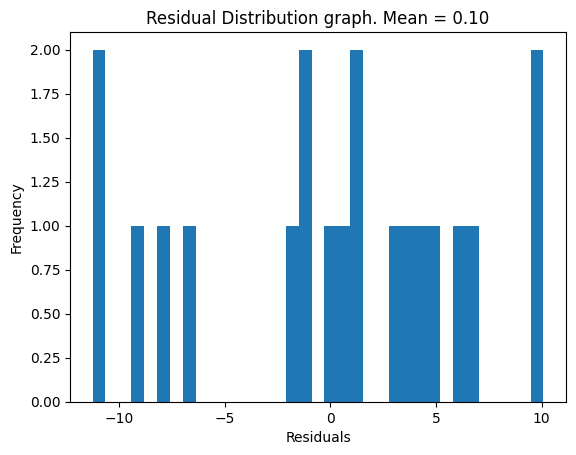

0.9184655307556575

In [46]:
from sklearn import linear_model

model = linear_model.ElasticNet()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

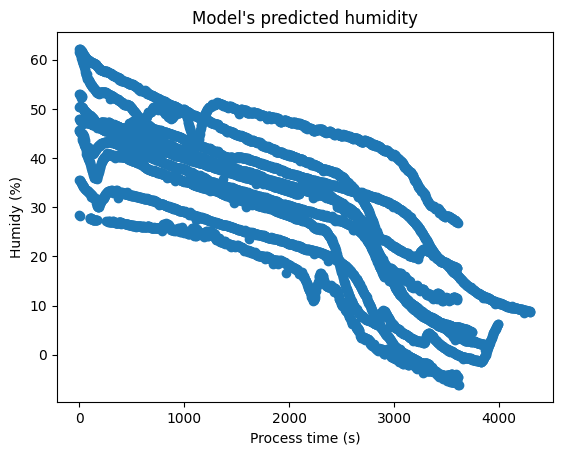

In [47]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Bayesian Ridge regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		15.45
Score		96.86%


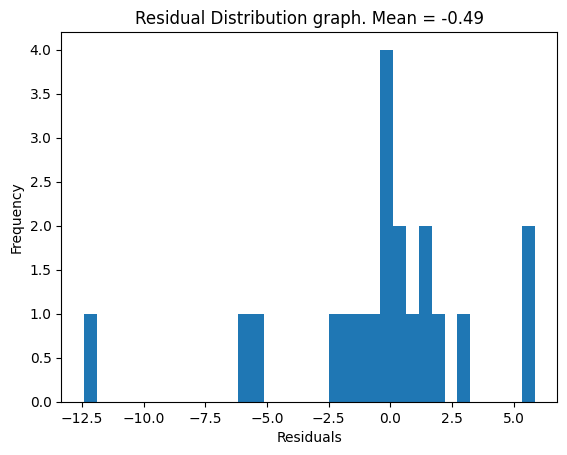

0.9685523299631019

In [48]:
from sklearn import linear_model

model = linear_model.BayesianRidge()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

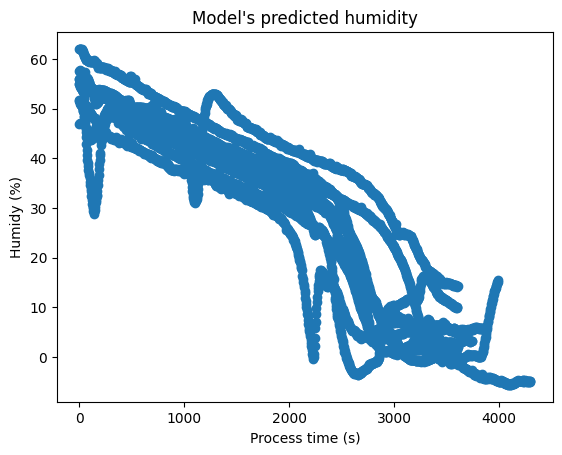

In [49]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Stochastic Gradient Descent regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		13.45
Score		97.26%


c:\Users\rapha\OneDrive\Documentos\GitHub\projects-tcc-imt-2023\venv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


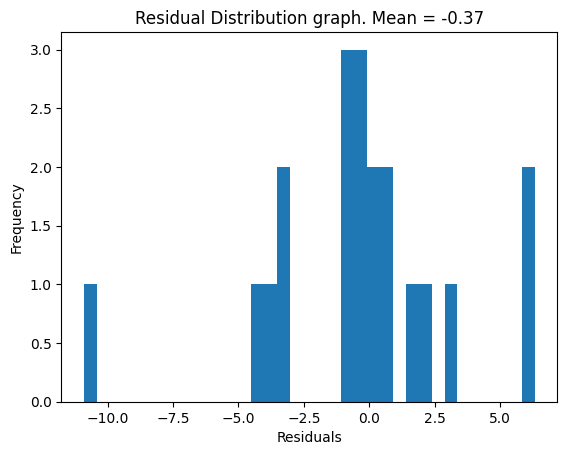

0.9726131784283683

In [50]:
from sklearn import linear_model

model = linear_model.SGDRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

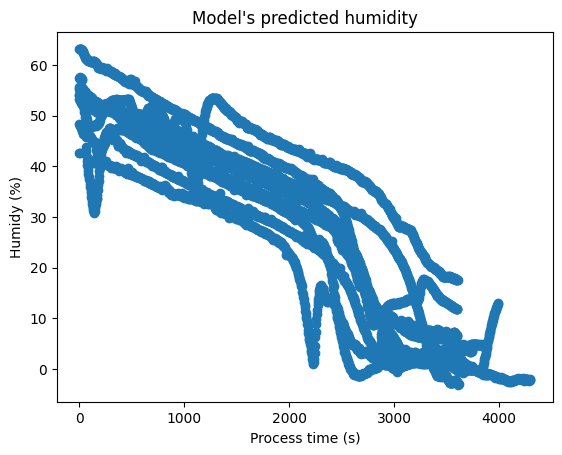

In [51]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Theil-Sen regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		13.52
Score		97.25%


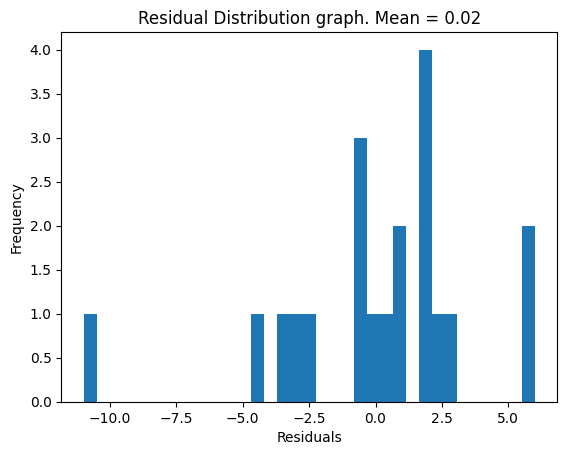

0.9724693109502016

In [52]:
from sklearn import linear_model

model = linear_model.TheilSenRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

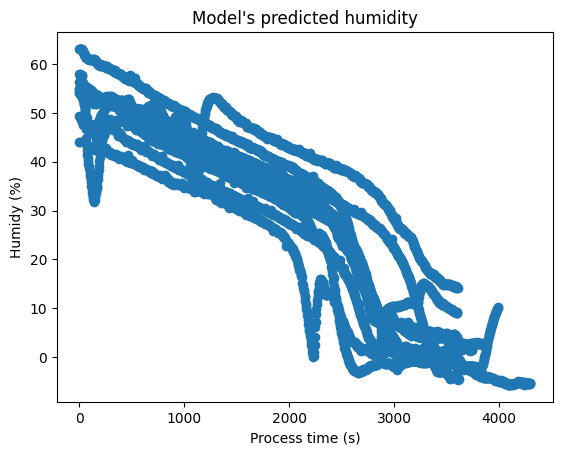

In [53]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Huber regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		15.13
Score		96.92%


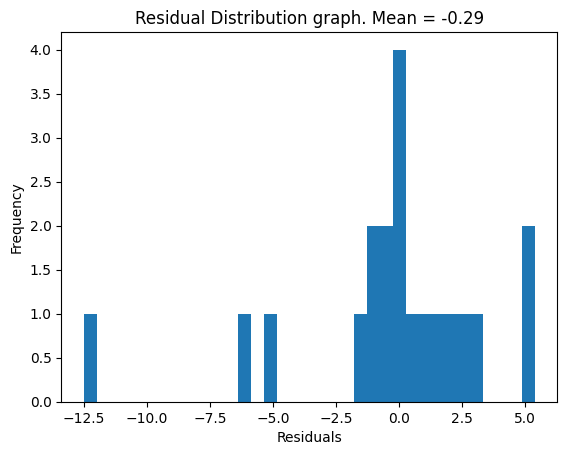

0.9691924428367877

In [54]:
from sklearn import linear_model

model = linear_model.HuberRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

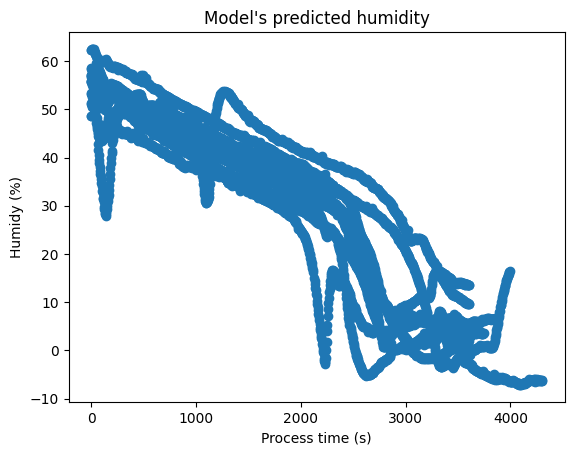

In [55]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Poisson regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		27.38
Score		94.09%


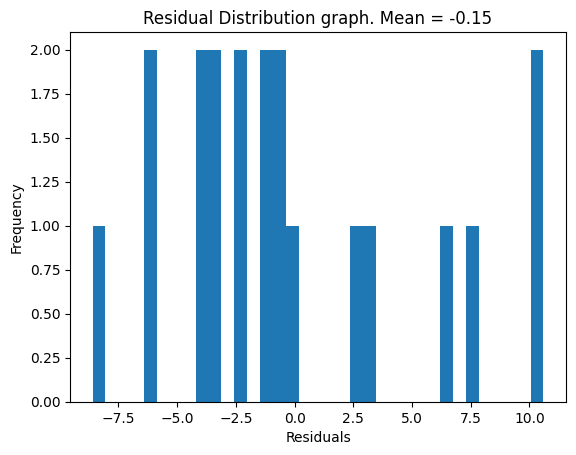

0.9408842791788936

In [56]:
from sklearn import linear_model

model = linear_model.PoissonRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

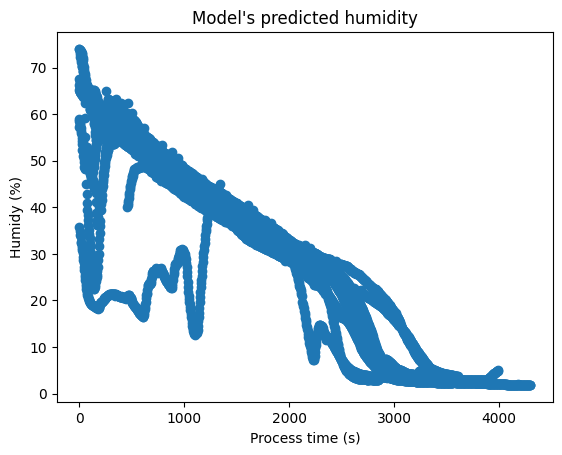

In [57]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

## Support Vector Machine

### Epsilon-Support Vector regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		264.58
Score		46.13%


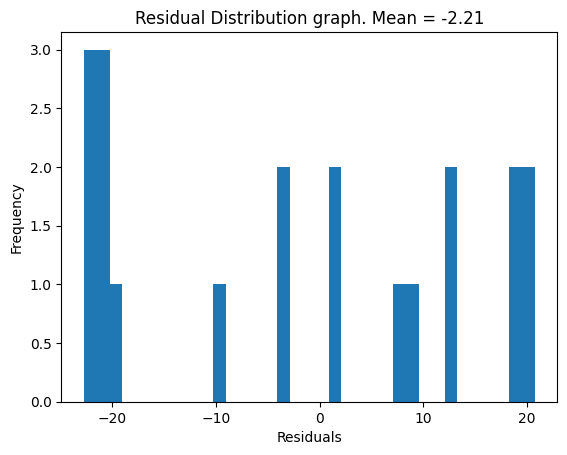

0.4613358208779613

In [58]:
from sklearn import svm

model = svm.SVR()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

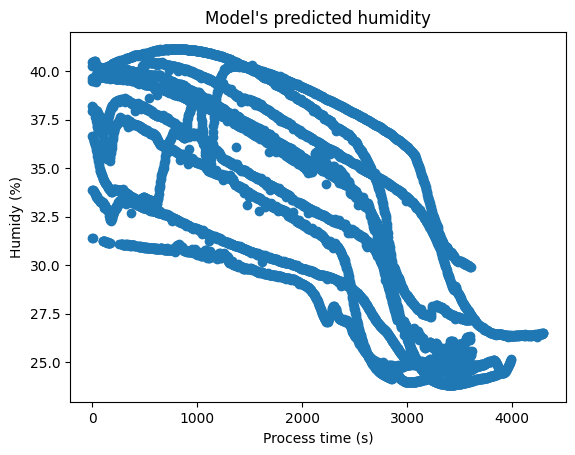

In [59]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Nu Support Vector regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		353.62
Score		28.01%


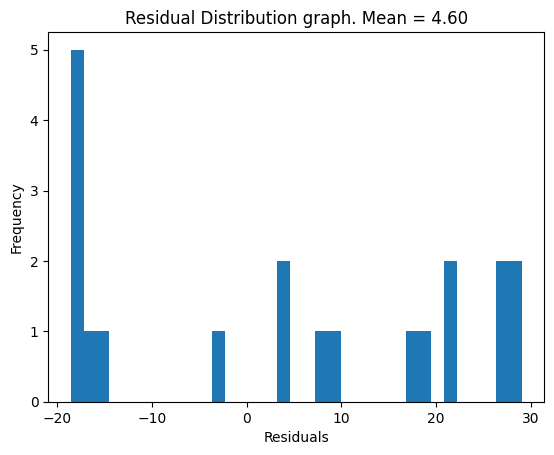

0.28005901410810885

In [60]:
from sklearn import svm

model = svm.NuSVR()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

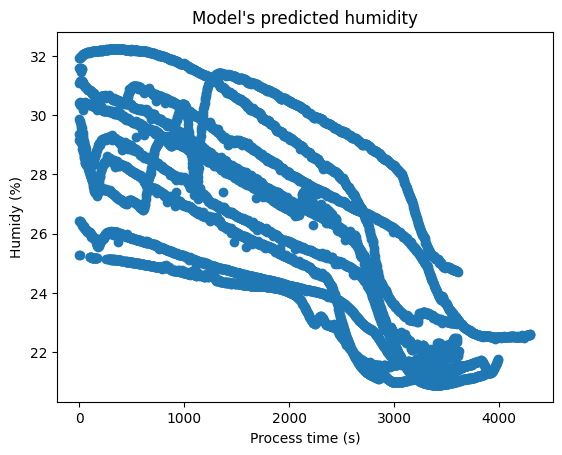

In [61]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

## Nearest Neighbors

In [62]:
k = 3

### K-nearest neighbors based regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		15.01
Score		96.94%


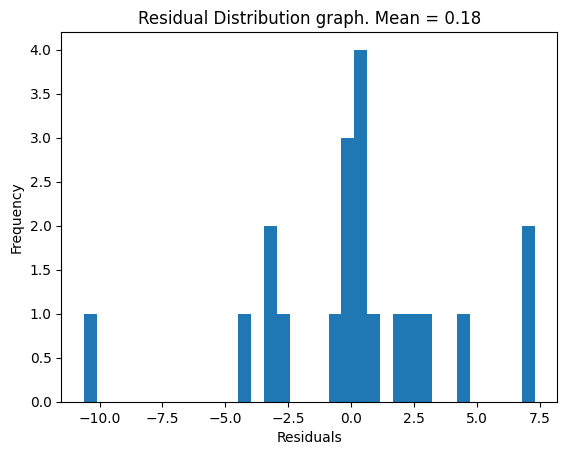

0.9694354630484285

In [63]:
from sklearn import neighbors

model = neighbors.KNeighborsRegressor(k)
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

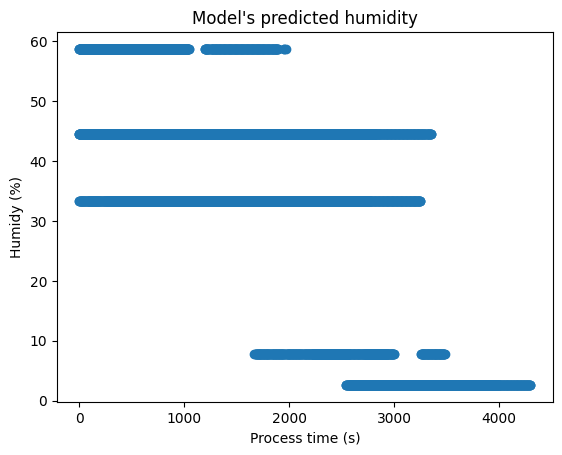

In [64]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Neighbors within a fixed radius based regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		155.02
Score		68.44%


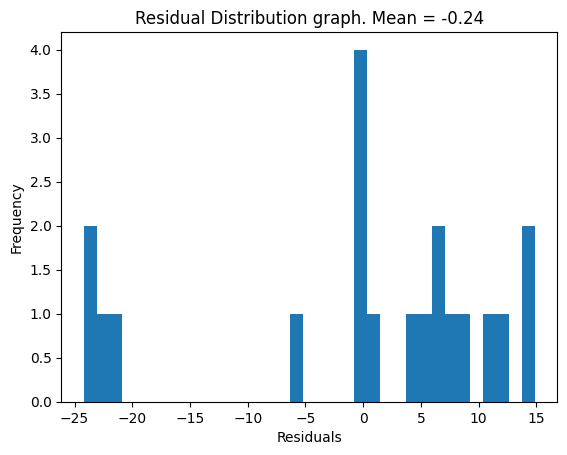

0.6843942416922014

In [65]:
from sklearn import neighbors

model = neighbors.RadiusNeighborsRegressor(k)
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

c:\Users\rapha\OneDrive\Documentos\GitHub\projects-tcc-imt-2023\venv\lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


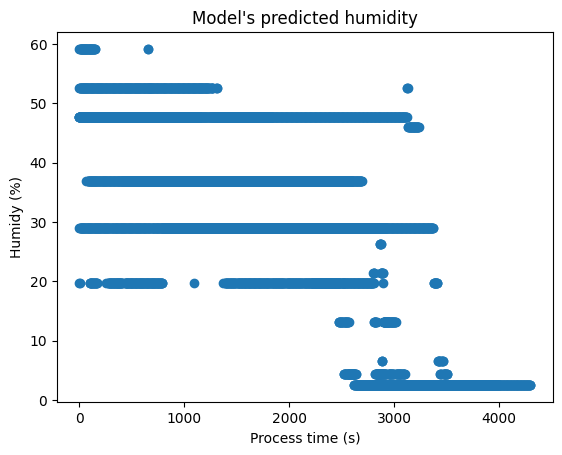

In [66]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

## Gaussian Processes

### Gaussian process regression

Mean Squared Error (MSE) lower = better
Score higher = better

MSE		16.47
Score		96.65%


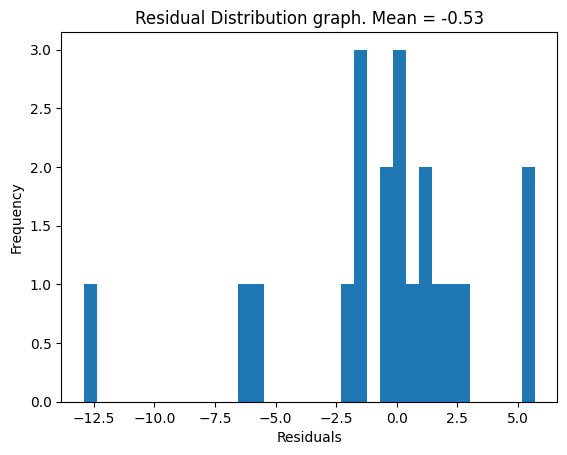

0.9664751479963425

In [67]:
from sklearn import gaussian_process

model = gaussian_process.GaussianProcessRegressor()
model.fit(X_train, y_train)

model_summary(y_test, X_test, model)

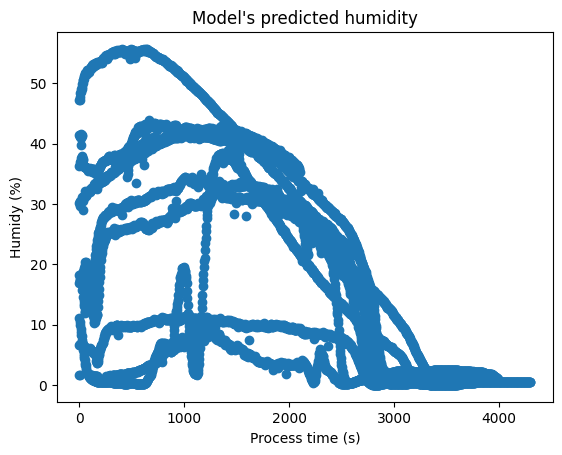

In [68]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

## Decision Trees

### Decision tree regressor


Training DecisionTreeRegressor model
0.5%	training time left 0:00:02s
1.0%	training time left 0:00:02s
1.5%	training time left 0:00:02s
2.0%	training time left 0:00:02s
2.5%	training time left 0:00:02s
3.0%	training time left 0:00:02s
3.5%	training time left 0:00:02s
4.0%	training time left 0:00:02s
4.5%	training time left 0:00:02s
5.0%	training time left 0:00:02s
5.5%	training time left 0:00:02s
6.0%	training time left 0:00:02s
6.5%	training time left 0:00:02s
7.0%	training time left 0:00:02s
7.5%	training time left 0:00:02s
8.0%	training time left 0:00:02s
8.5%	training time left 0:00:02s
9.0%	training time left 0:00:01s
9.5%	training time left 0:00:01s
10.0%	training time left 0:00:01s
10.5%	training time left 0:00:01s
11.0%	training time left 0:00:01s
11.5%	training time left 0:00:01s
12.0%	training time left 0:00:01s
12.5%	training time left 0:00:01s
13.0%	training time left 0:00:01s
13.5%	training time left 0:00:01s
14.0%	training time left 0:00:01s
14.5%	training time left 0:00

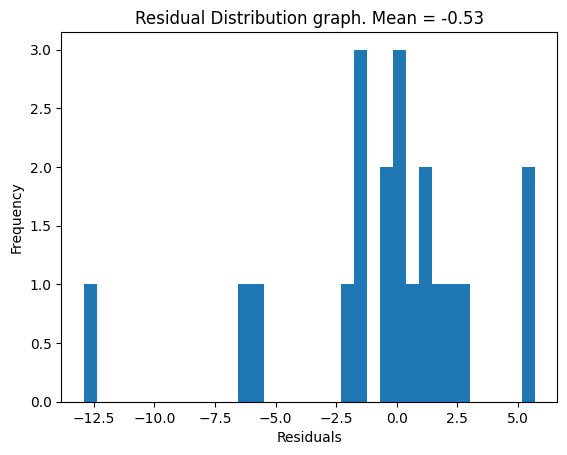

In [69]:
from sklearn import tree

model = None
try:
    model = load_instance('./models-persisted/DecisionTreeRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = tree.DecisionTreeRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

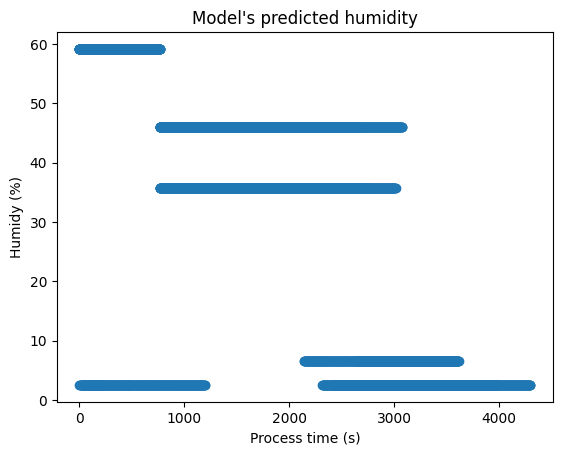

In [70]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Extremely randomized tree regressor


Training ExtraTreeRegressor model
0.5%	training time left 0:00:02s
1.0%	training time left 0:00:02s
1.5%	training time left 0:00:02s
2.0%	training time left 0:00:02s
2.5%	training time left 0:00:02s
3.0%	training time left 0:00:02s
3.5%	training time left 0:00:02s
4.0%	training time left 0:00:02s
4.5%	training time left 0:00:02s
5.0%	training time left 0:00:02s
5.5%	training time left 0:00:02s
6.0%	training time left 0:00:02s
6.5%	training time left 0:00:02s
7.0%	training time left 0:00:01s
7.5%	training time left 0:00:01s
8.0%	training time left 0:00:01s
8.5%	training time left 0:00:01s
9.0%	training time left 0:00:01s
9.5%	training time left 0:00:01s
10.0%	training time left 0:00:01s
10.5%	training time left 0:00:01s
11.0%	training time left 0:00:01s
11.5%	training time left 0:00:01s
12.0%	training time left 0:00:01s
12.5%	training time left 0:00:01s
13.0%	training time left 0:00:01s
13.5%	training time left 0:00:01s
14.0%	training time left 0:00:01s
14.5%	training time left 0:00:01

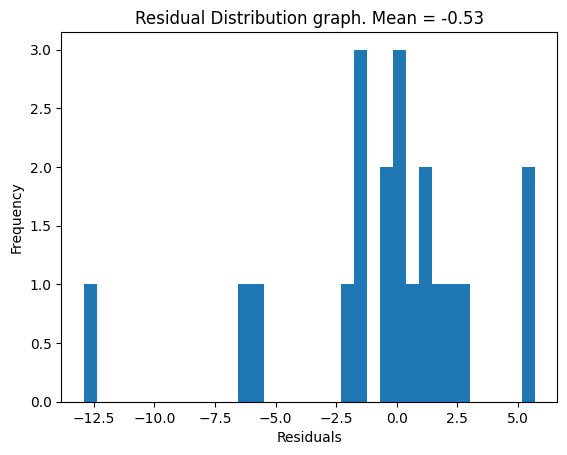

In [71]:
from sklearn import tree

model = None
try:
    model = load_instance('./models-persisted/ExtraTreeRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = tree.ExtraTreeRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

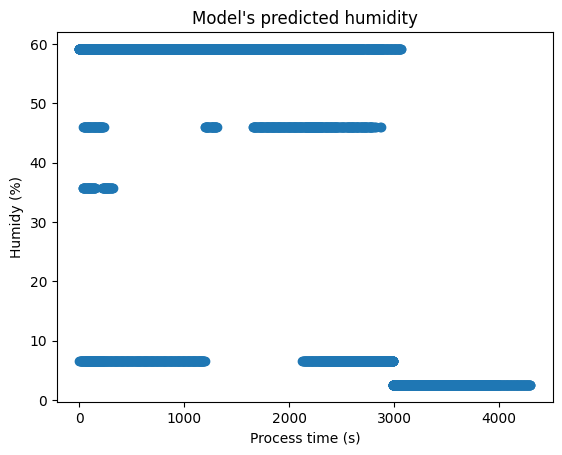

In [72]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

## Ensemble methods

Regressors are `not` idempotent

### Bagging regressor


Training BaggingRegressor model
0.5%	training time left 0:00:11s
1.0%	training time left 0:00:11s
1.5%	training time left 0:00:10s
2.0%	training time left 0:00:10s
2.5%	training time left 0:00:10s
3.0%	training time left 0:00:10s
3.5%	training time left 0:00:10s
4.0%	training time left 0:00:10s
4.5%	training time left 0:00:10s
5.0%	training time left 0:00:10s
5.5%	training time left 0:00:10s
6.0%	training time left 0:00:10s
6.5%	training time left 0:00:10s
7.0%	training time left 0:00:10s
7.5%	training time left 0:00:10s
8.0%	training time left 0:00:10s
8.5%	training time left 0:00:10s
9.0%	training time left 0:00:10s
9.5%	training time left 0:00:10s
10.0%	training time left 0:00:10s
10.5%	training time left 0:00:10s
11.0%	training time left 0:00:10s
11.5%	training time left 0:00:10s
12.0%	training time left 0:00:10s
12.5%	training time left 0:00:10s
13.0%	training time left 0:00:09s
13.5%	training time left 0:00:09s
14.0%	training time left 0:00:09s
14.5%	training time left 0:00:09s


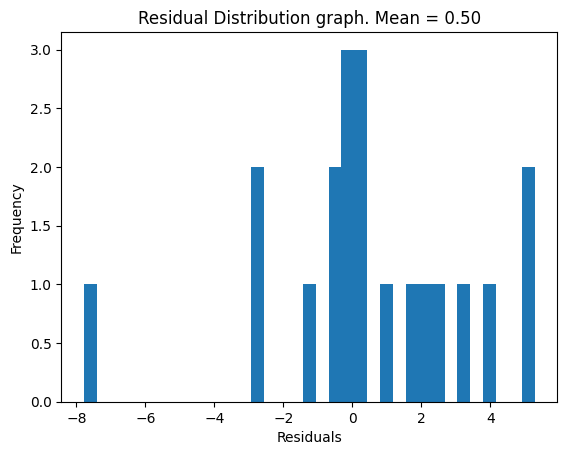

In [73]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/BaggingRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.BaggingRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

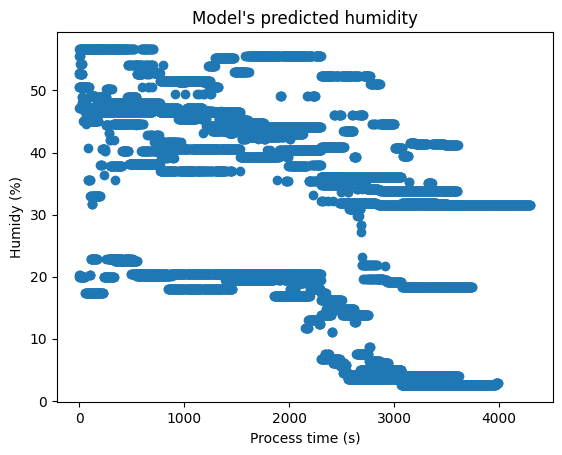

In [74]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### AdaBoost regressor


Training AdaBoostRegressor model
0.5%	training time left 0:00:08s
1.0%	training time left 0:00:07s
1.5%	training time left 0:00:06s
2.0%	training time left 0:00:06s
2.5%	training time left 0:00:06s
3.0%	training time left 0:00:06s
3.5%	training time left 0:00:06s
4.0%	training time left 0:00:06s
4.5%	training time left 0:00:06s
5.0%	training time left 0:00:06s
5.5%	training time left 0:00:06s
6.0%	training time left 0:00:06s
6.5%	training time left 0:00:06s
7.0%	training time left 0:00:06s
7.5%	training time left 0:00:06s
8.0%	training time left 0:00:06s
8.5%	training time left 0:00:06s
9.0%	training time left 0:00:06s
9.5%	training time left 0:00:06s
10.0%	training time left 0:00:06s
10.5%	training time left 0:00:06s
11.0%	training time left 0:00:05s
11.5%	training time left 0:00:05s
12.0%	training time left 0:00:05s
12.5%	training time left 0:00:05s
13.0%	training time left 0:00:05s
13.5%	training time left 0:00:05s
14.0%	training time left 0:00:05s
14.5%	training time left 0:00:05s

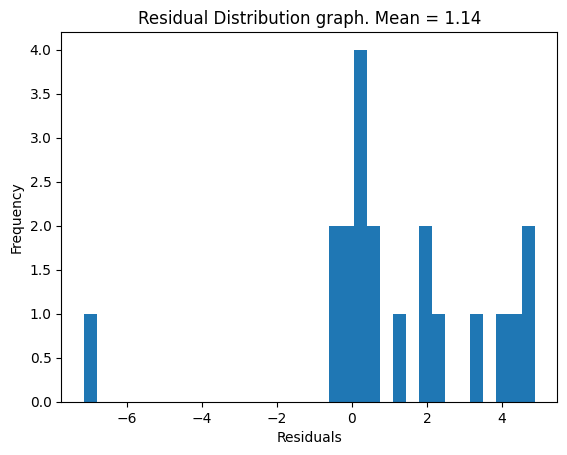

In [75]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/AdaBoostRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.AdaBoostRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

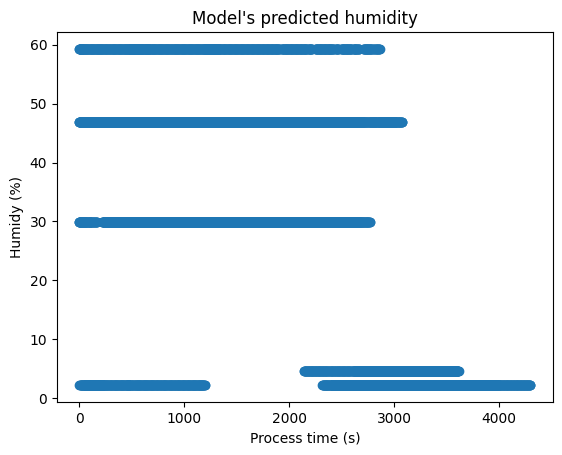

In [76]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Extra-trees regressor

This regressor differs from `tree.ExtraTreeRegressor` because it uses averaging to improve the predictive accuracy and control over-fitting using a number of randomized decision trees.


Training ExtraTreesRegressor model
0.5%	training time left 0:00:54s
1.0%	training time left 0:00:53s
1.5%	training time left 0:00:52s
2.0%	training time left 0:00:52s
2.5%	training time left 0:00:52s
3.0%	training time left 0:00:52s
3.5%	training time left 0:00:51s
4.0%	training time left 0:00:51s
4.5%	training time left 0:00:51s
5.0%	training time left 0:00:50s
5.5%	training time left 0:00:50s
6.0%	training time left 0:00:49s
6.5%	training time left 0:00:49s
7.0%	training time left 0:00:49s
7.5%	training time left 0:00:49s
8.0%	training time left 0:00:49s
8.5%	training time left 0:00:48s
9.0%	training time left 0:00:48s
9.5%	training time left 0:00:48s
10.0%	training time left 0:00:48s
10.5%	training time left 0:00:48s
11.0%	training time left 0:00:47s
11.5%	training time left 0:00:47s
12.0%	training time left 0:00:47s
12.5%	training time left 0:00:46s
13.0%	training time left 0:00:46s
13.5%	training time left 0:00:46s
14.0%	training time left 0:00:45s
14.5%	training time left 0:00:4

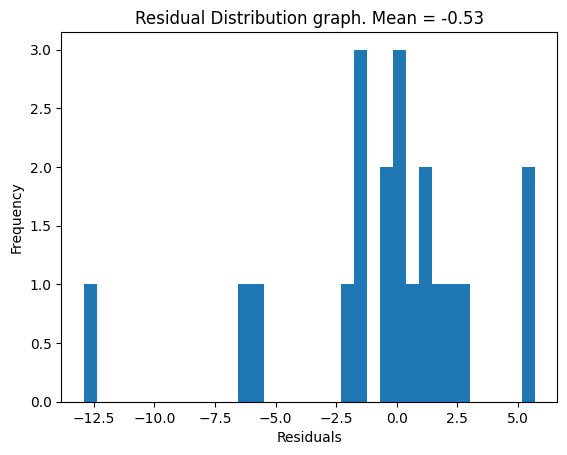

In [77]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/ExtraTreesRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.ExtraTreesRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

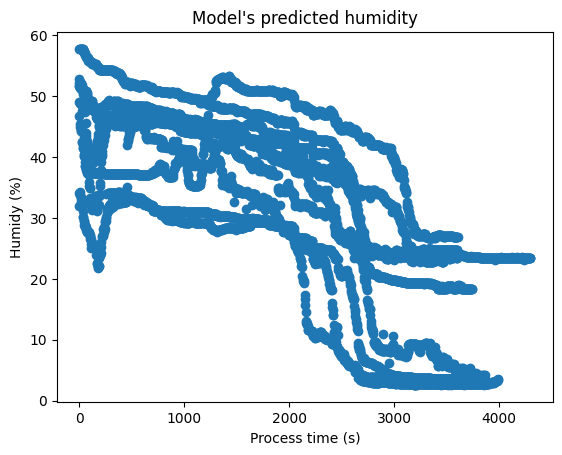

In [78]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Random forest regressor


Training RandomForestRegressor model
0.5%	training time left 0:01:11s
1.0%	training time left 0:01:11s
1.5%	training time left 0:01:11s
2.0%	training time left 0:01:11s
2.5%	training time left 0:01:10s
3.0%	training time left 0:01:09s
3.5%	training time left 0:01:08s
4.0%	training time left 0:01:08s
4.5%	training time left 0:01:08s
5.0%	training time left 0:01:08s
5.5%	training time left 0:01:09s
6.0%	training time left 0:01:07s
6.5%	training time left 0:01:07s
7.0%	training time left 0:01:06s
7.5%	training time left 0:01:06s
8.0%	training time left 0:01:06s
8.5%	training time left 0:01:05s
9.0%	training time left 0:01:05s
9.5%	training time left 0:01:04s
10.0%	training time left 0:01:03s
10.5%	training time left 0:01:03s
11.0%	training time left 0:01:02s
11.5%	training time left 0:01:02s
12.0%	training time left 0:01:01s
12.5%	training time left 0:01:01s
13.0%	training time left 0:01:00s
13.5%	training time left 0:01:00s
14.0%	training time left 0:00:59s
14.5%	training time left 0:00

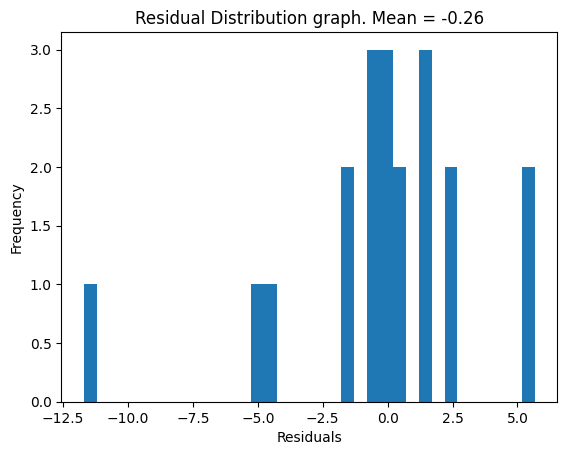

In [79]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/RandomForestRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.RandomForestRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

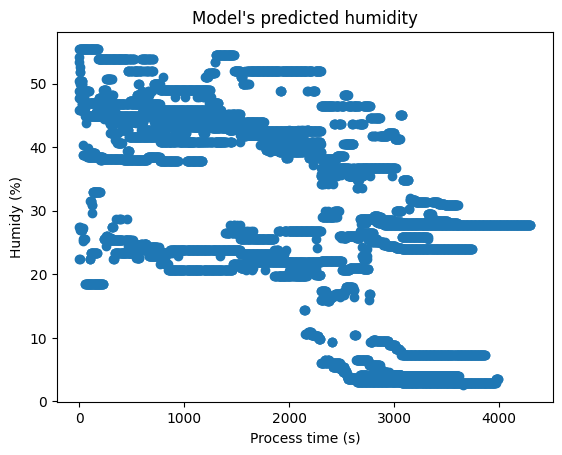

In [80]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Gradient Boosting for regression


Training GradientBoostingRegressor model
0.5%	training time left 0:00:24s
1.0%	training time left 0:00:23s
1.5%	training time left 0:00:23s
2.0%	training time left 0:00:22s
2.5%	training time left 0:00:22s
3.0%	training time left 0:00:21s
3.5%	training time left 0:00:21s
4.0%	training time left 0:00:21s
4.5%	training time left 0:00:21s
5.0%	training time left 0:00:20s
5.5%	training time left 0:00:20s
6.0%	training time left 0:00:20s
6.5%	training time left 0:00:20s
7.0%	training time left 0:00:19s
7.5%	training time left 0:00:19s
8.0%	training time left 0:00:19s
8.5%	training time left 0:00:19s
9.0%	training time left 0:00:19s
9.5%	training time left 0:00:19s
10.0%	training time left 0:00:19s
10.5%	training time left 0:00:19s
11.0%	training time left 0:00:19s
11.5%	training time left 0:00:19s
12.0%	training time left 0:00:19s
12.5%	training time left 0:00:18s
13.0%	training time left 0:00:18s
13.5%	training time left 0:00:18s
14.0%	training time left 0:00:18s
14.5%	training time left 

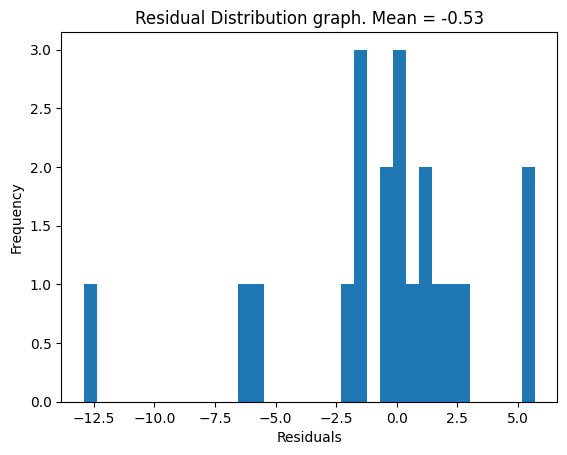

In [81]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/GradientBoostingRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.GradientBoostingRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

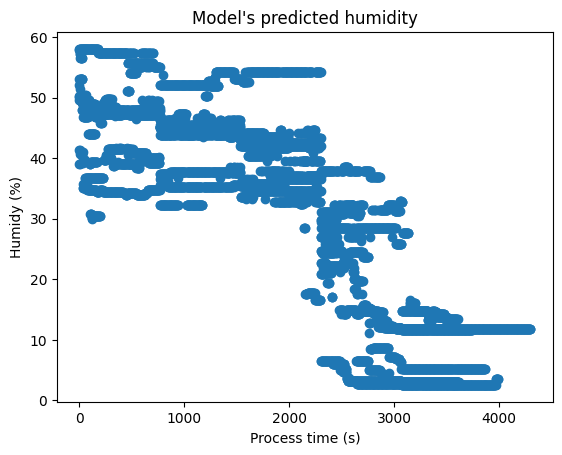

In [82]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

### Histogram-based Gradient Boosting Regression Tree


Training HistGradientBoostingRegressor model
0.5%	training time left 0:00:43s
1.0%	training time left 0:00:42s
1.5%	training time left 0:00:42s
2.0%	training time left 0:00:41s
2.5%	training time left 0:00:41s
3.0%	training time left 0:00:41s
3.5%	training time left 0:00:41s
4.0%	training time left 0:00:40s
4.5%	training time left 0:00:40s
5.0%	training time left 0:00:40s
5.5%	training time left 0:00:40s
6.0%	training time left 0:00:40s
6.5%	training time left 0:00:40s
7.0%	training time left 0:00:39s
7.5%	training time left 0:00:39s
8.0%	training time left 0:00:39s
8.5%	training time left 0:00:39s
9.0%	training time left 0:00:39s
9.5%	training time left 0:00:38s
10.0%	training time left 0:00:38s
10.5%	training time left 0:00:38s
11.0%	training time left 0:00:38s
11.5%	training time left 0:00:38s
12.0%	training time left 0:00:37s
12.5%	training time left 0:00:37s
13.0%	training time left 0:00:37s
13.5%	training time left 0:00:37s
14.0%	training time left 0:00:37s
14.5%	training time l

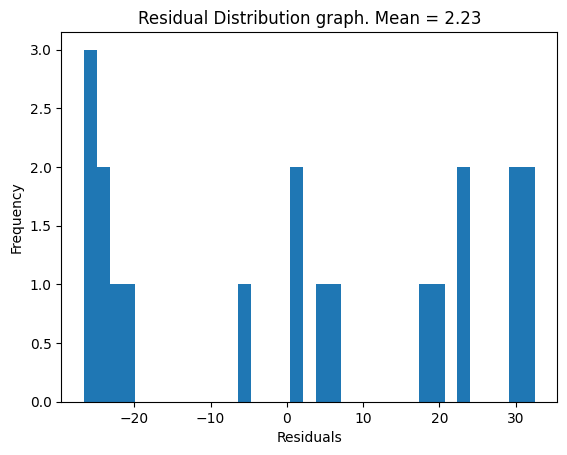

In [83]:
from sklearn import ensemble

model = None
try:
    model = load_instance('./models-persisted/HistGradientBoostingRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = ensemble.HistGradientBoostingRegressor()
    model = get_best_from_simple_fit_model(
        model, X_train, y_train, X_test, y_test
    )

    print()

    model_summary(y_test, X_test, model)

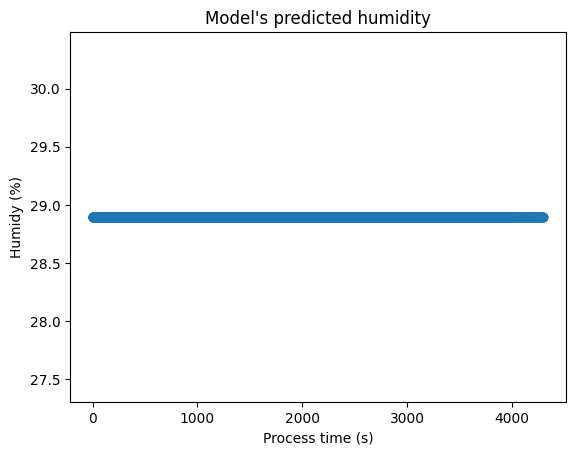

In [84]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

## Neural network models

### Multi-layer Perceptron regressor


Mean Squared Error (MSE) lower = better
Score higher = better

MSE		17.12
Score		96.52%


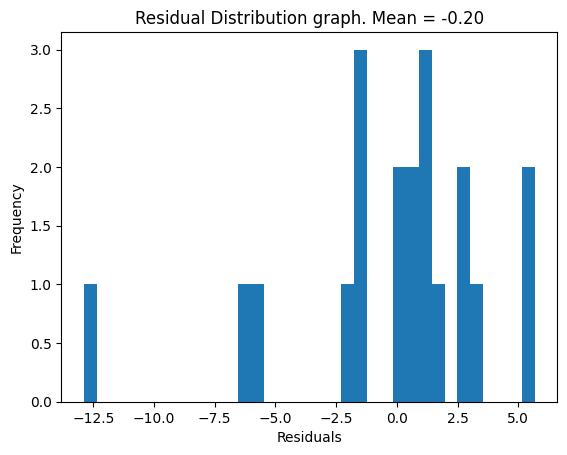

In [85]:
from sklearn import neural_network

model = None
try:
    model = load_instance('./models-persisted/MLPRegressor.pkl')
    print()

    model_summary(y_test, X_test, model)
except:
    model = neural_network.MLPRegressor(
        hidden_layer_sizes=[20, 20, 20],
        activation='tanh',
        max_iter=10000
    )
    model.fit(X_train, y_train)

    print()

    model_summary(y_test, X_test, model)

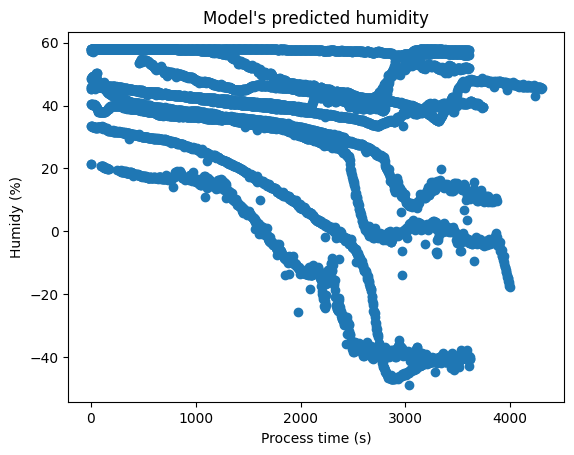

In [86]:
import matplotlib.pyplot as plt

humidy = model.predict(data_controller_use_case.df_norm)
time = data_controller_use_case.df['Time']

plt.title("Model's predicted humidity")
plt.scatter(time, humidy)
plt.xlabel('Process time (s)')
plt.ylabel('Humidy (%)')
plt.show()

## Results

In [33]:
from json import dumps

with open('result.json', 'w') as outfile:
    outfile.write(dumps(models_result))